## Regression Model Training + Testing

In [1]:
import pandas as pd
import numpy as np

In [2]:
expression_df = pd.read_csv("../data/processed_data/expression_data.csv")

In [3]:
drug_response_df = pd.read_csv("../data/processed_data/drug_response_data.csv")

Make sure data is aligned

In [4]:
common_ids = expression_df.index.intersection(drug_response_df.index)

X = expression_df.loc[common_ids]
y = drug_response_df.loc[common_ids]

assert (X.index == y.index).all() ## does nothing if WORKS, will throw error otherwise, keep that as a note

No error, therefore it is aligned

#### Selecting Drugs to Train

First we must determine which drugs will the model be trained on

In [5]:
valid_counts = drug_response_df.notna().sum()
training_drugs = valid_counts[valid_counts >= 50].index.tolist()
print(len(training_drugs))

127


In [6]:
print(training_drugs)

['COSMIC_ID', '5-Fluorouracil', 'ABT737', 'AGI-5198', 'AGK2', 'AMG-319', 'AT13148', 'AZ6102', 'AZD3759', 'AZD4547', 'AZD5363', 'AZD6738', 'AZD7762', 'AZD8186', 'Afatinib', 'Afuresertib', 'Alpelisib', 'Avagacestat', 'Axitinib', 'BIBR-1532', 'BMS-536924', 'BMS-754807', 'Bortezomib', 'Bosutinib', 'Buparlisib', 'Camptothecin', 'Cediranib', 'Cisplatin', 'Crizotinib', 'Cyclophosphamide', 'Dabrafenib', 'Dactinomycin', 'Dactolisib', 'Dasatinib', 'Docetaxel', 'Doramapimod', 'EHT-1864', 'EPZ004777', 'EPZ5676', 'Entinostat', 'Epirubicin', 'Erlotinib', 'Foretinib', 'Fulvestrant', 'GDC0810', 'GNE-317', 'GSK1904529A', 'GSK2578215A', 'GSK343', 'GSK591', 'Gefitinib', 'Gemcitabine', 'I-BRD9', 'Ipatasertib', 'Irinotecan', 'JQ1', 'KU-55933', 'LGK974', 'LJI308', 'Lapatinib', 'Lenalidomide', 'Lestaurtinib', 'Linsitinib', 'Luminespib', 'MG-132', 'MIRA-1', 'MK-1775', 'MK-2206', 'MK-8776', 'Motesanib', 'NU7441', 'NVP-ADW742', 'Navitoclax', 'Nilotinib', 'Nutlin-3a (-)', 'OSI-027', 'Olaparib', 'Osimertinib', 'O

In [7]:
training_drugs = training_drugs[1 :]
print(training_drugs)

['5-Fluorouracil', 'ABT737', 'AGI-5198', 'AGK2', 'AMG-319', 'AT13148', 'AZ6102', 'AZD3759', 'AZD4547', 'AZD5363', 'AZD6738', 'AZD7762', 'AZD8186', 'Afatinib', 'Afuresertib', 'Alpelisib', 'Avagacestat', 'Axitinib', 'BIBR-1532', 'BMS-536924', 'BMS-754807', 'Bortezomib', 'Bosutinib', 'Buparlisib', 'Camptothecin', 'Cediranib', 'Cisplatin', 'Crizotinib', 'Cyclophosphamide', 'Dabrafenib', 'Dactinomycin', 'Dactolisib', 'Dasatinib', 'Docetaxel', 'Doramapimod', 'EHT-1864', 'EPZ004777', 'EPZ5676', 'Entinostat', 'Epirubicin', 'Erlotinib', 'Foretinib', 'Fulvestrant', 'GDC0810', 'GNE-317', 'GSK1904529A', 'GSK2578215A', 'GSK343', 'GSK591', 'Gefitinib', 'Gemcitabine', 'I-BRD9', 'Ipatasertib', 'Irinotecan', 'JQ1', 'KU-55933', 'LGK974', 'LJI308', 'Lapatinib', 'Lenalidomide', 'Lestaurtinib', 'Linsitinib', 'Luminespib', 'MG-132', 'MIRA-1', 'MK-1775', 'MK-2206', 'MK-8776', 'Motesanib', 'NU7441', 'NVP-ADW742', 'Navitoclax', 'Nilotinib', 'Nutlin-3a (-)', 'OSI-027', 'Olaparib', 'Osimertinib', 'Oxaliplatin', 

We can see that the drugs with at least 50 samples is the most effective number since we get 127 drugs. If we increase the samples to 52 we only get 14 samples. However to be safe we will:
- Log the number of samples used per drug
- Use cross-validation per drug to mitigate variance
- Prioritize post-analysis of drugs with best regression performance or biological relevance

#### Deciding the Regression Model to Use

To help determine what model is best, we will first plot some graphs to help us determine any relationships

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

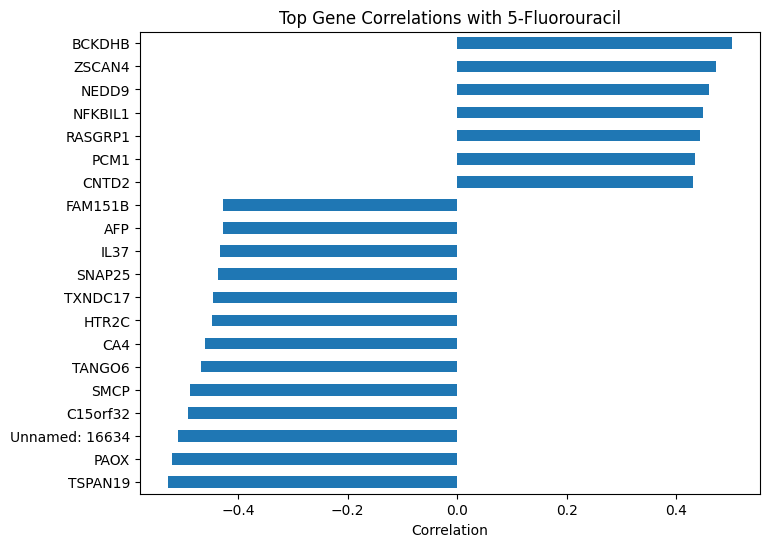

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

drug = training_drugs[0]

# Get cell lines with non-null drug response
y = drug_response_df[drug].dropna()

# Intersect again with expression data just in case
common_index = y.index.intersection(expression_df.index)

# Final aligned X and y
y = y.loc[common_index]
X = expression_df.loc[common_index]

# Assuming y = drug response for one drug
# and X = expression data aligned to y

# 1. Compute correlation between each gene and drug response
correlations = X.corrwith(y).dropna()

# 2. Get top 20 genes by **absolute correlation**
top_genes = correlations.abs().sort_values(ascending=False).head(20).index
correlations[top_genes].sort_values().plot(kind='barh', figsize=(8, 6))
plt.title(f"Top Gene Correlations with {drug}")
plt.xlabel("Correlation")
plt.show()

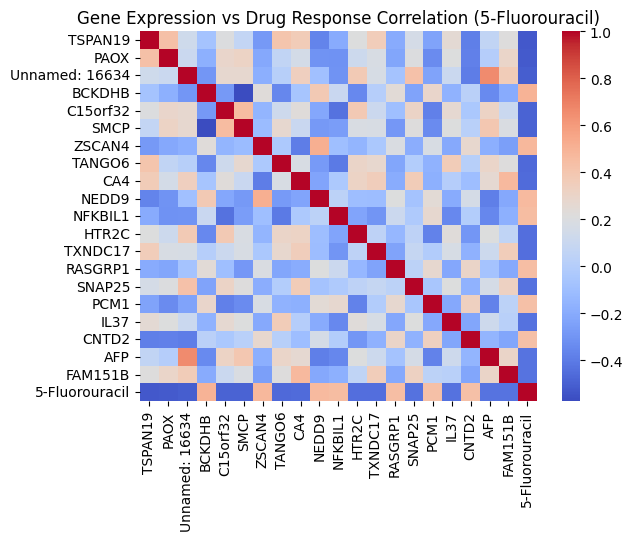

In [12]:

correlations = X.corrwith(y).dropna()
top_genes = correlations.abs().sort_values(ascending=False).head(20).index

sns.heatmap(X[top_genes].join(y).corr(), cmap="coolwarm", annot=False)
plt.title(f"Gene Expression vs Drug Response Correlation ({drug})")
plt.show()


#### Model Testing